In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import scipy.signal as signal

plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (20,8)
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 14

In [2]:
data = pd.read_csv('Prepared Datasets/Mar2019Aug2019rs1h.csv')
data.datetime = pd.to_datetime(data.datetime)
data.set_index('datetime', inplace=True)

<h1>Exploratory Data Analysis for Data Collected in the Heating Period of 2019</h1>

The analysis includes data collected from March 15, 2019 to August 16, 2019

The data are resampled in 1 hour intervals

The sensors that were recording data during this time were:

<ul>
    <li>YieldPoint's Extensometer 1: Temperature, Apperture (Located between pillars K and J)</li>
    <li>YieldPoint's Extensometer 2: Temperature, Apperture (Located between pillar K and West Wall Exc. Boundary)</li>
    <li>YieldPoint's Rock Temperature Array: Rock Temperature at 11 elevations along pillar K, starting from the bottom of the pillar</li>
    <li>InkBird Sensor -  Roof: Air Temperature at the collapsed Ceiling, Relative Humidity Inside</li>
    <li>InkBird Sensor - Facade: Air Temperature and Relative Humidity at the exterior facade</li>


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2956 entries, 2019-04-15 00:00:00 to 2019-08-16 06:00:00
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   air_temp_ext1       2956 non-null   float64
 1   apperture_ext1      2956 non-null   float64
 2   aprtr_change_ext1   2956 non-null   float64
 3   air_temp_ext2       2956 non-null   float64
 4   apperture_ext2      2956 non-null   float64
 5   aprtr_change_ext2   2956 non-null   float64
 6   t1_rta              2956 non-null   float64
 7   t2_rta              2956 non-null   float64
 8   t3_rta              2956 non-null   float64
 9   t4_rta              2956 non-null   float64
 10  t5_rta              2956 non-null   float64
 11  t6_rta              2956 non-null   float64
 12  t7_rta              2956 non-null   float64
 13  t8_rta              2956 non-null   float64
 14  t9_rta              2956 non-null   float64
 15  t11_rta            

The dataset contains 2995 data points for each sensor

<h2>Plots of Temperature</h2>

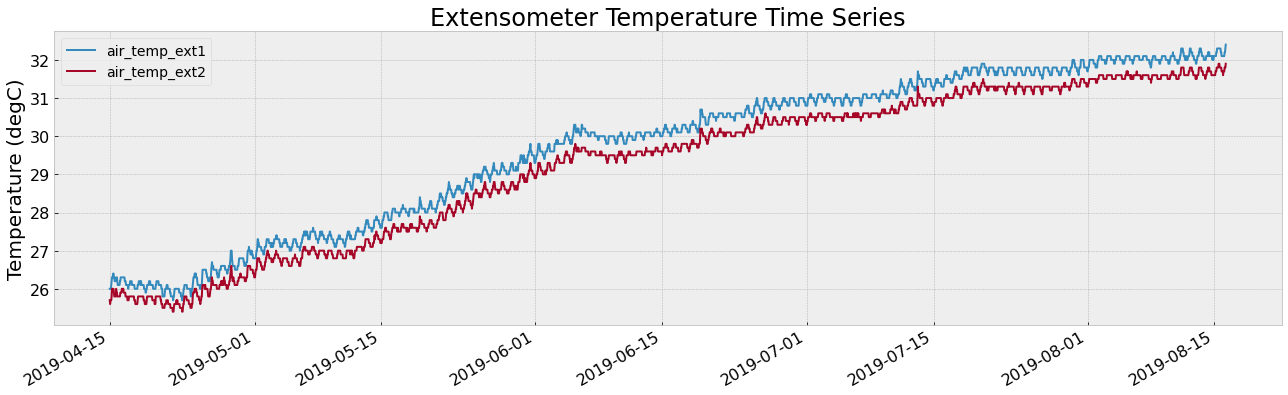

In [4]:
fig = data.loc[:, ['air_temp_ext1', 'air_temp_ext2']].plot(figsize=(22,6))
ax = fig.axes
ax.set_title('Extensometer Temperature Time Series')
ax.set_xlabel('')
ax.set_ylabel('Temperature (degC)')
plt.show()

In [5]:
mean, std = (data['air_temp_ext1'] - data['air_temp_ext2']).mean(), (data['air_temp_ext1'] - data['air_temp_ext2']).std()
print(f'Temp Difference between Ext1 and Ext2\nMean: {mean:.3f}\nStD: {std:.3f}')

Temp Difference between Ext1 and Ext2
Mean: 0.445
StD: 0.062


Temperature is rising steadily in the instrument location. There is a sharper rise in temperature from mid-April up until the second week of Huned which then slows down. Some small distinct jumps can be observed and happen around the same time in both extensometers. Temperature at Ext1 is half a degree higher than Temperature at Ext2, possibly due to the proximity to the entrance

The IB sensors are used to measure the ambient (exterior) temperature near the roof and at the facade of the tomb. The sensor measurements disagree with the roof temperature recording a cooling pattern which should not really be the case. Revisit data analysis to fix mistake

In [6]:
# TODO resultant vectors
#data['disp_csum_ext1'], data['disp_csum_ext2'] = data.aprtr_change_ext1.cumsum(), data.aprtr_change_ext2.cumsum()


x = data.aprtr_change_ext1.cumsum()
y = data.aprtr_change_ext2.cumsum()


data['disp_rext']= np.sqrt(x**2 + y**2)
theta = np.rad2deg(np.arctan2(x,y+0.000001))
theta = (theta + 90) % 360
data['azim_rext'] = theta.apply(lambda x: x if x > 0 else 360+x)

data['disp_rext_change'] = data.disp_rext.diff()
data['azim_rext_change'] = data.azim_rext.diff()

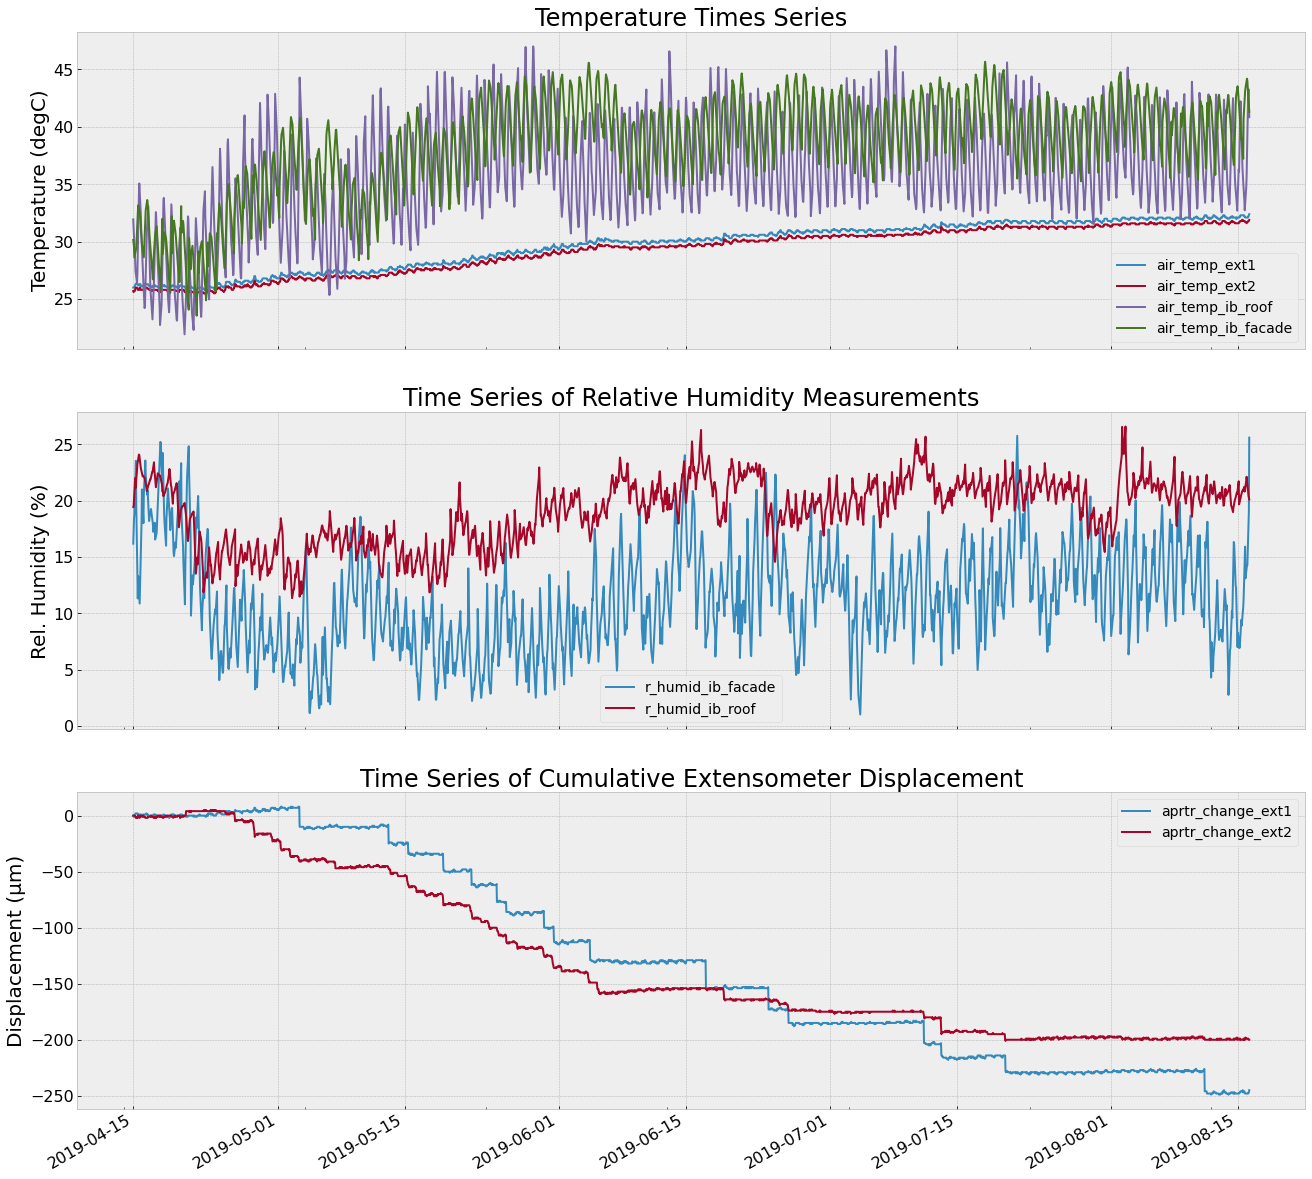

In [7]:
fig,axs = plt.subplots(3,1, sharex=True, figsize=(22,22))

ax=axs[0]
data.loc[:, ['air_temp_ext1', 'air_temp_ext2','air_temp_ib_roof', 'air_temp_ib_facade']].plot(ax=ax, legend=True)
ax.set_title('Temperature Times Series')
ax.set_ylabel('Temperature (degC)')
ax.set_xlabel('')
ax.legend()

ax=axs[1]
data.loc[:, ['r_humid_ib_facade', 'r_humid_ib_roof']].plot(ax=ax, legend=True)
ax.set_title('Time Series of Relative Humidity Measurements')
ax.set_ylabel('Rel. Humidity (%)')
ax.set_xlabel('')

ax=axs[2]
data.loc[:, ['aprtr_change_ext1', 'aprtr_change_ext2']].cumsum().plot(ax=ax, legend=True)
ax.set_title('Time Series of Cumulative Extensometer Displacement')
ax.set_ylabel('Displacement (μm)')
ax.set_xlabel('')

plt.show()

Text(0, 0.5, 'Angle (deg)')

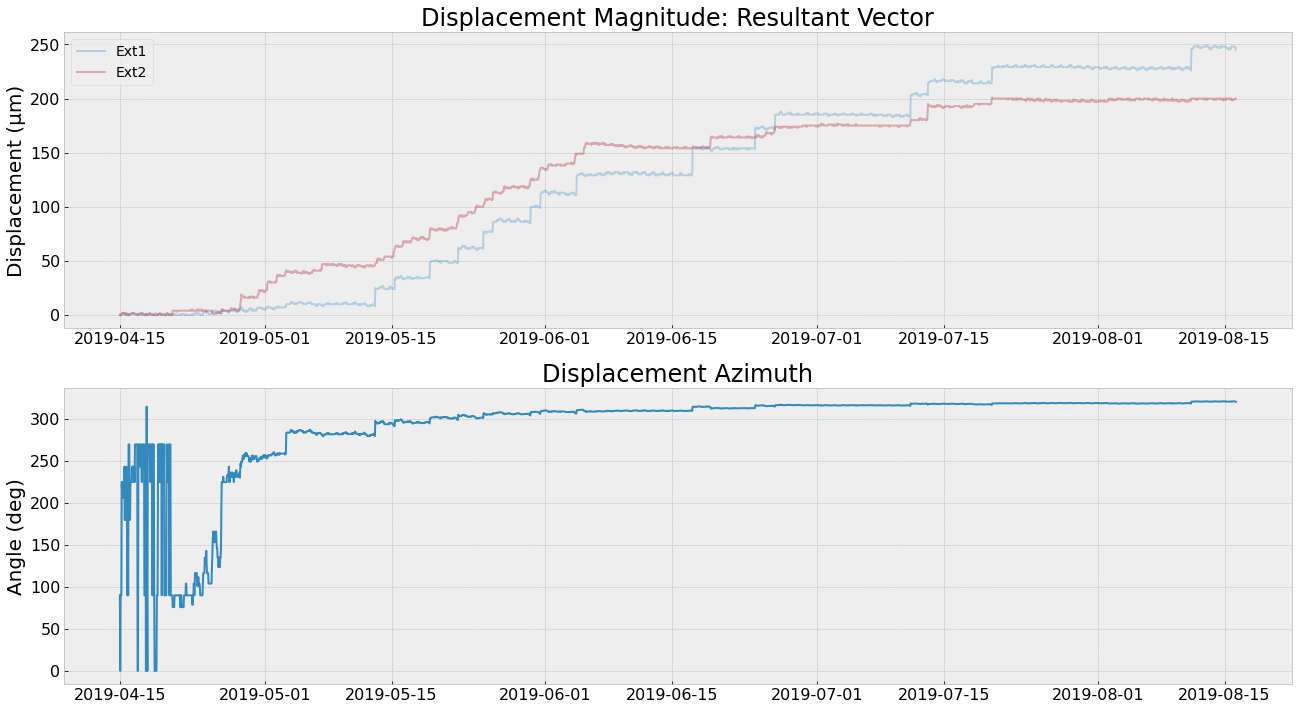

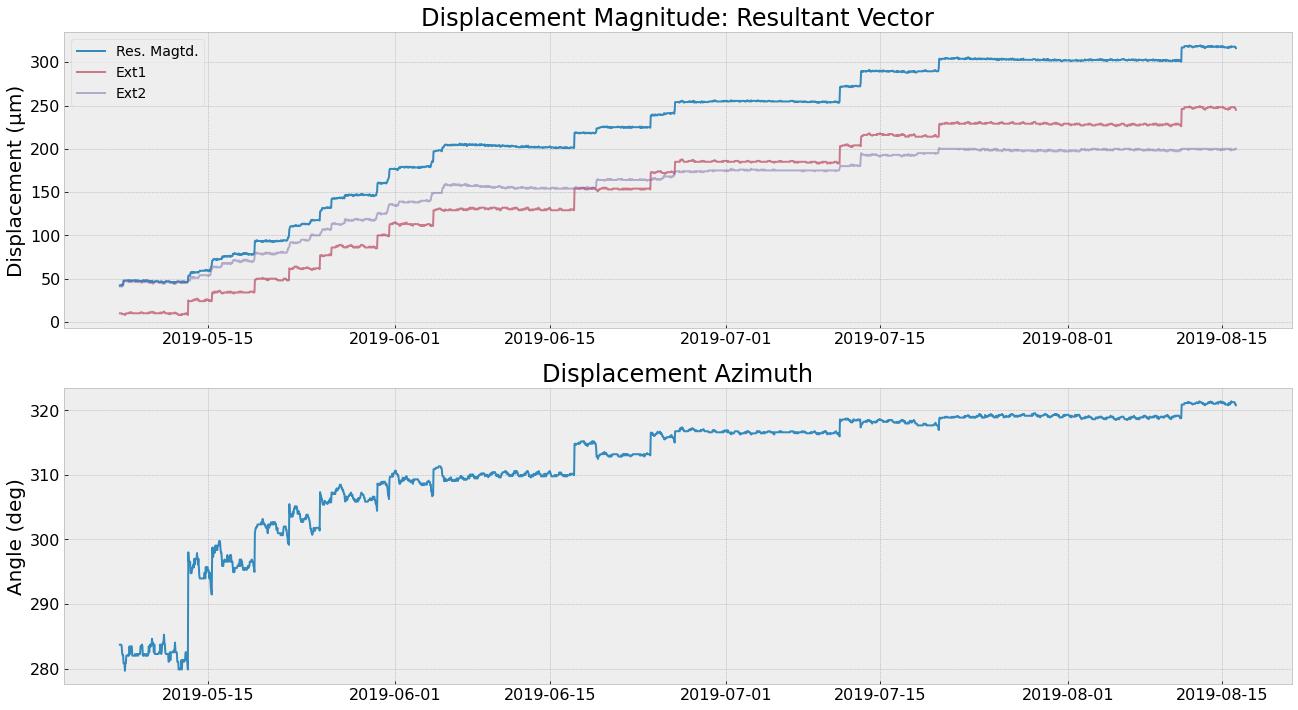

In [8]:
fig, axs = plt.subplots(2,1, figsize=(22,12))

ax = axs[0]
#ax.plot(data['disp_rext'], label = 'Res. Magtd.')
ax.plot(np.abs(data.aprtr_change_ext1.cumsum()), alpha=0.3, label='Ext1')
ax.plot(np.abs(data.aprtr_change_ext2.cumsum()), alpha=0.3, label='Ext2')
ax.set_title('Displacement Magnitude: Resultant Vector')
ax.set_ylabel('Displacement (μm)')
ax.legend()

ax = axs[1]
ax.plot(data['azim_rext'])
ax.set_title('Displacement Azimuth')
ax.set_ylabel('Angle (deg)')


fig, axs = plt.subplots(2,1, figsize=(22,12))

ax = axs[0]
ax.plot(data['disp_rext'].loc['2019-05-07':], label = 'Res. Magtd.')
ax.plot(np.abs(data.aprtr_change_ext1.cumsum().loc['2019-05-07':]), alpha=0.5, label='Ext1')
ax.plot(np.abs(data.aprtr_change_ext2.cumsum().loc['2019-05-07':]), alpha=0.5, label='Ext2')
ax.set_title('Displacement Magnitude: Resultant Vector')
ax.set_ylabel('Displacement (μm)')
ax.legend()

ax = axs[1]
ax.plot(data['azim_rext'].loc['2019-05-07':])
ax.set_title('Displacement Azimuth')
ax.set_ylabel('Angle (deg)')


In [9]:
#jumps = data.apperture_ecumsumff()[(data.apperture_ext1.diff() < -2) | (data.apperture_ext1.diff() > 2)]
data['is_jump_ext1'] = data.aprtr_change_ext1.apply(lambda x: True if abs(x) > 2*data.aprtr_change_ext1.std() else False)
data['is_jump_ext2'] = data.aprtr_change_ext2.apply(lambda x: True if abs(x) > 2*data.aprtr_change_ext2.std() else False)
data['is_jump_rext'] = data.disp_rext.diff().apply(lambda x: True if abs(x) > 2*data.disp_rext.diff().std() else False)

jumps_ext1 = data[data['is_jump_ext1']]
jumps_ext2 = data[data['is_jump_ext2']]
jumps_rext = data[data['is_jump_rext']]

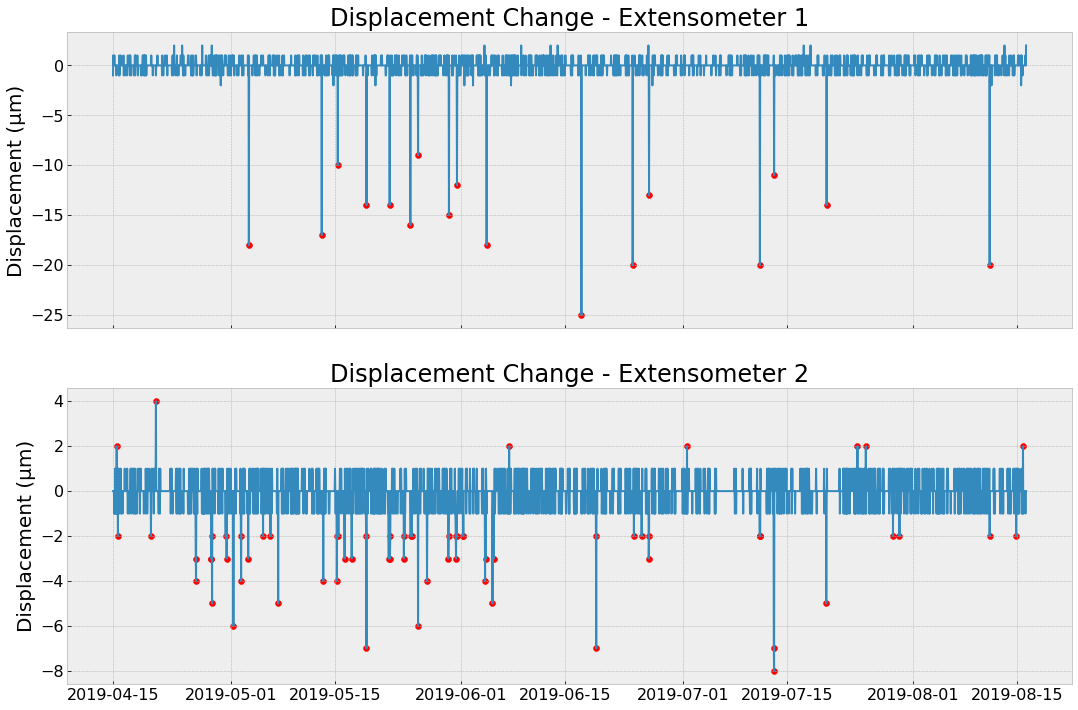

In [10]:
fig, axs = plt.subplots(2,1,sharex=True, figsize=(18,12))

ax=axs[0]
ax.plot(data.apperture_ext1.diff())
ax.scatter(jumps_ext1.index, jumps_ext1.aprtr_change_ext1, c='red')
ax.set_title('Displacement Change - Extensometer 1')
ax.set_ylabel('Displacement (μm)')
ax.set_xlabel('')

ax=axs[1]
ax.plot(data.apperture_ext2.diff())
ax.scatter(jumps_ext2.index, jumps_ext2['aprtr_change_ext2'], c='red')
ax.set_title('Displacement Change - Extensometer 2')
ax.set_ylabel('Displacement (μm)')
ax.set_xlabel('')

# ax=axs[2]
# ax.plot(data.disp_rext.diff())
# ax.scatter(jumps_rext.index, jumps_rext['disp_rext_change'], c='red')
# ax.set_title('Displacement Change - Extensometer 2')
# ax.set_ylabel('Displacement (μm)')
# ax.set_xlabel('')

plt.show()

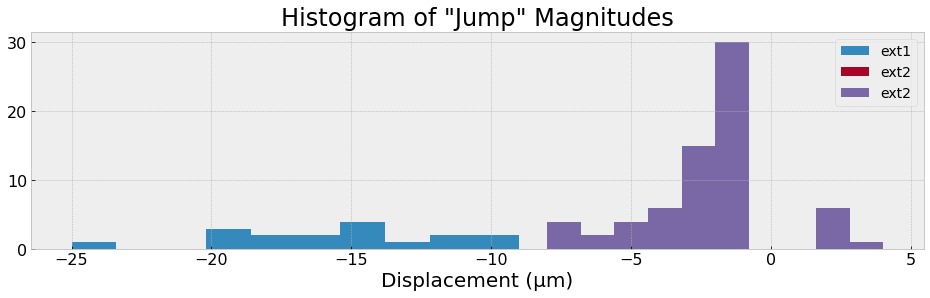

In [11]:
fig, ax = plt.subplots(figsize=(16,4), sharex=True)

ax.hist(jumps_ext1['aprtr_change_ext1'], label='ext1')
ax.hist(jumps_ext2['aprtr_change_ext2'], label='ext2')
ax.hist(jumps_ext2['aprtr_change_ext2'], label='ext2')
ax.set_title('Histogram of "Jump" Magnitudes')
ax.set_xlabel('Displacement (μm)')
ax.legend()


In [12]:
print(f'Mean Jump Magnitude - Ext1: {jumps_ext1.aprtr_change_ext1.mean():.2f} μm')
print(f'Jump Standard Deviation - Ext1: {jumps_ext1.aprtr_change_ext1.std():.2f} μm')
print()
print(f'Mean Jump Magnitude - Ext2: {jumps_ext2.aprtr_change_ext2.mean():.2f} μm')
print(f'Jump Standard Deviation - Ext2: {jumps_ext2.aprtr_change_ext2.std():.2f} μm')

Mean Jump Magnitude - Ext1: -15.65 μm
Jump Standard Deviation - Ext1: 4.21 μm

Mean Jump Magnitude - Ext2: -2.56 μm
Jump Standard Deviation - Ext2: 2.22 μm


C:\Users\vasil\AppData\Local\Temp\ipykernel_3416\383885220.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  sbplts = data.loc[:, ['air_temp_ib_roof', 'air_temp_ib_facade','air_temp_ext1']].diff().plot(subplots=True,


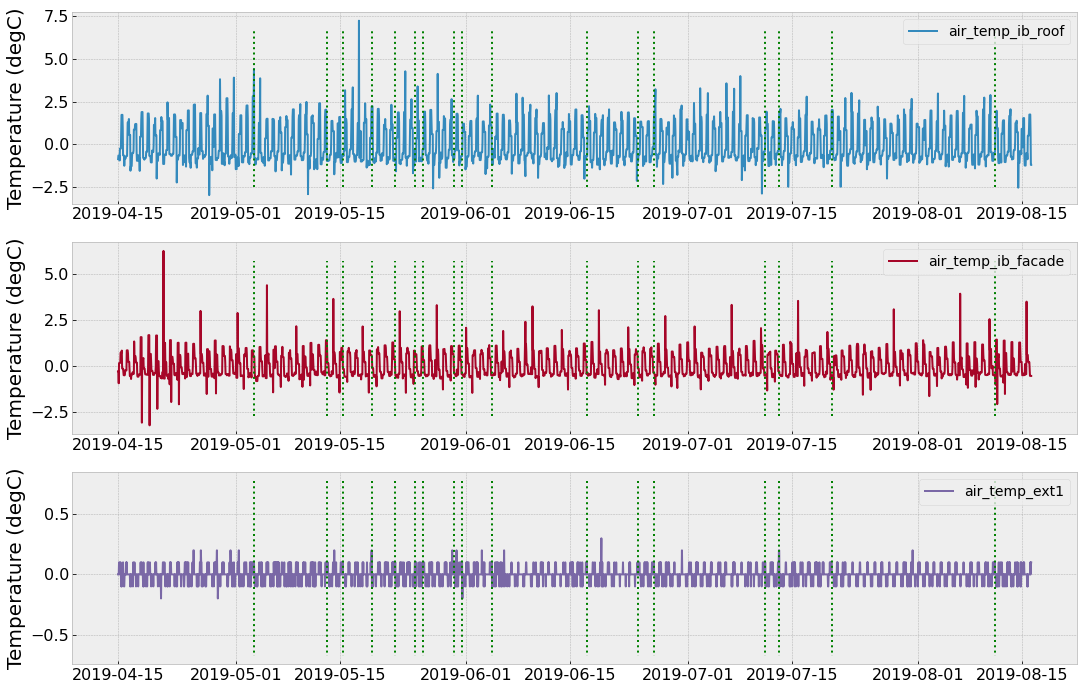

In [13]:
ax=plt.figure(figsize=(18,12)).gca()
sbplts = data.loc[:, ['air_temp_ib_roof', 'air_temp_ib_facade','air_temp_ext1']].diff().plot(subplots=True,
                                                                                    #sharey=['air_temp_ib_roof', 'air_temp_ib_facade','air_temp_ext1'],
                                                                                    ax=ax)

for plot in sbplts:
    ymin, ymax = plot.get_ylim()
    plot.vlines(jumps_ext1.index, ymin=ymin+1, ymax=ymax-1, colors='green', ls=':', lw=2)
    ax = plot.axes
    ax.set_xlabel('')
    ax.set_ylabel('Temperature (degC)')
    
plt.show()

C:\Users\vasil\AppData\Local\Temp\ipykernel_3416\524442535.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  sbplts = data.loc[:, ['air_temp_ib_roof', 'air_temp_ib_facade','air_temp_ext2']].diff().plot(subplots=True,


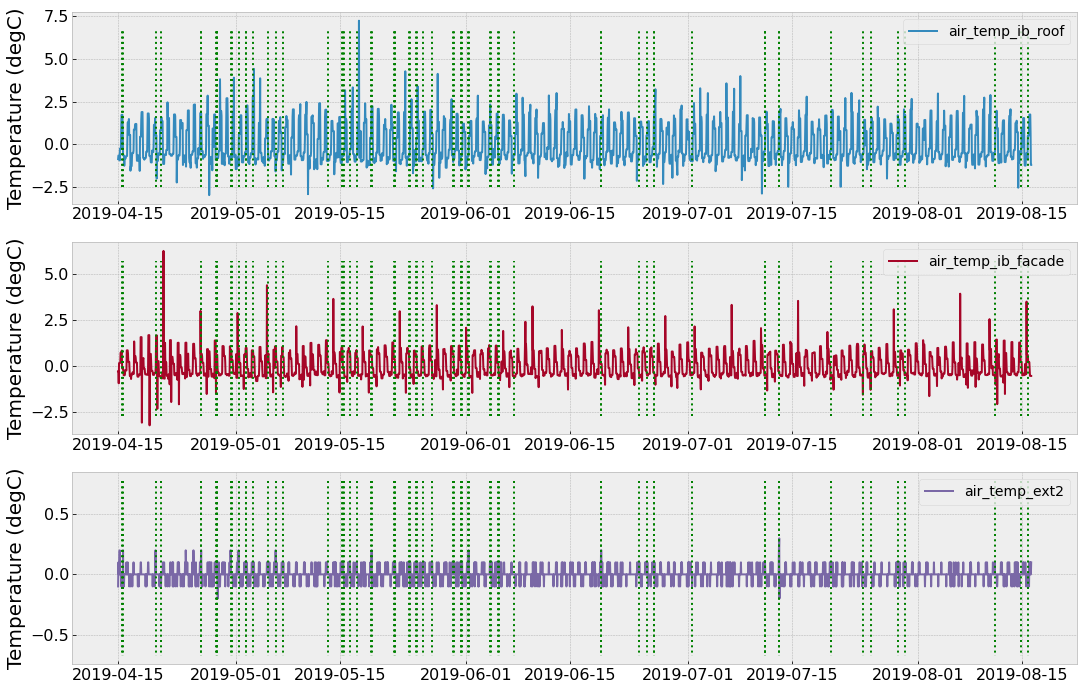

In [14]:
ax=plt.figure(figsize=(18,12)).gca()
sbplts = data.loc[:, ['air_temp_ib_roof', 'air_temp_ib_facade','air_temp_ext2']].diff().plot(subplots=True,
                                                                                    #sharey=['air_temp_ib_roof', 'air_temp_ib_facade','air_temp_ext1'],
                                                                                    ax=ax)

for plot in sbplts:
    ymin, ymax = plot.get_ylim()
    plot.vlines(jumps_ext2.index, ymin=ymin+1, ymax=ymax-1, colors='green', ls=':', lw=2)
    ax = plot.axes
    ax.set_xlabel('')
    ax.set_ylabel('Temperature (degC)')
    
plt.show()

C:\Users\vasil\AppData\Local\Temp\ipykernel_3416\1915864276.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  sbplts = data.loc[:, ['r_humid_ib_roof', 'r_humid_ib_facade']].diff().plot(subplots=True, ax=ax)


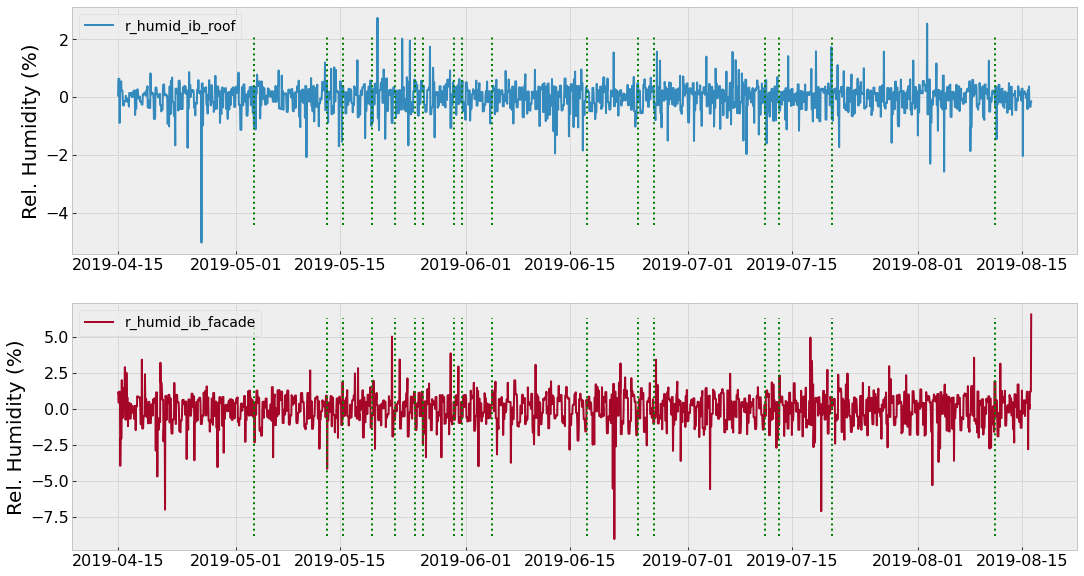

In [15]:
ax=plt.figure(figsize=(18,10)).gca()
sbplts = data.loc[:, ['r_humid_ib_roof', 'r_humid_ib_facade']].diff().plot(subplots=True, ax=ax)

for plot in sbplts:
    ymin, ymax = plot.get_ylim()
    plot.vlines(jumps_ext1.index, ymin=ymin+1, ymax=ymax-1, colors='green', ls=':', lw=2)
    plot.set_xlabel('')
    plot.set_ylabel('Rel. Humidity (%)')

plt.show()

C:\Users\vasil\AppData\Local\Temp\ipykernel_3416\3426261095.py:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  sbplts = data.loc[:, ['r_humid_ib_roof', 'r_humid_ib_facade']].diff().plot(subplots=True, ax=ax)


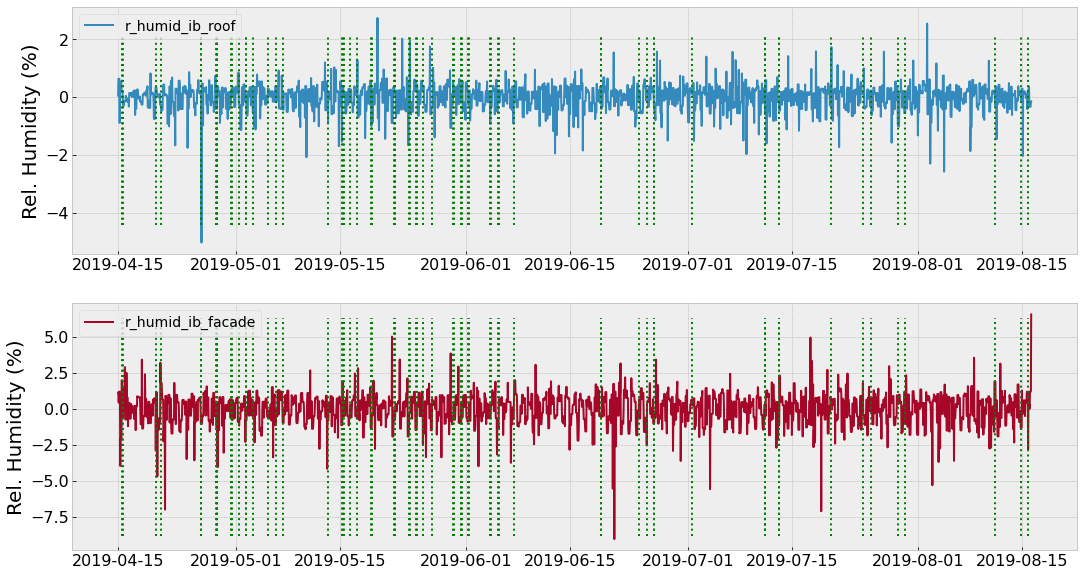

In [16]:
ax=plt.figure(figsize=(18,10)).gca()
sbplts = data.loc[:, ['r_humid_ib_roof', 'r_humid_ib_facade']].diff().plot(subplots=True, ax=ax)

for plot in sbplts:
    ymin, ymax = plot.get_ylim()
    plot.vlines(jumps_ext2.index, ymin=ymin+1, ymax=ymax-1, colors='green', ls=':', lw=2)
    plot.set_xlabel('')
    plot.set_ylabel('Rel. Humidity (%)')

plt.show()

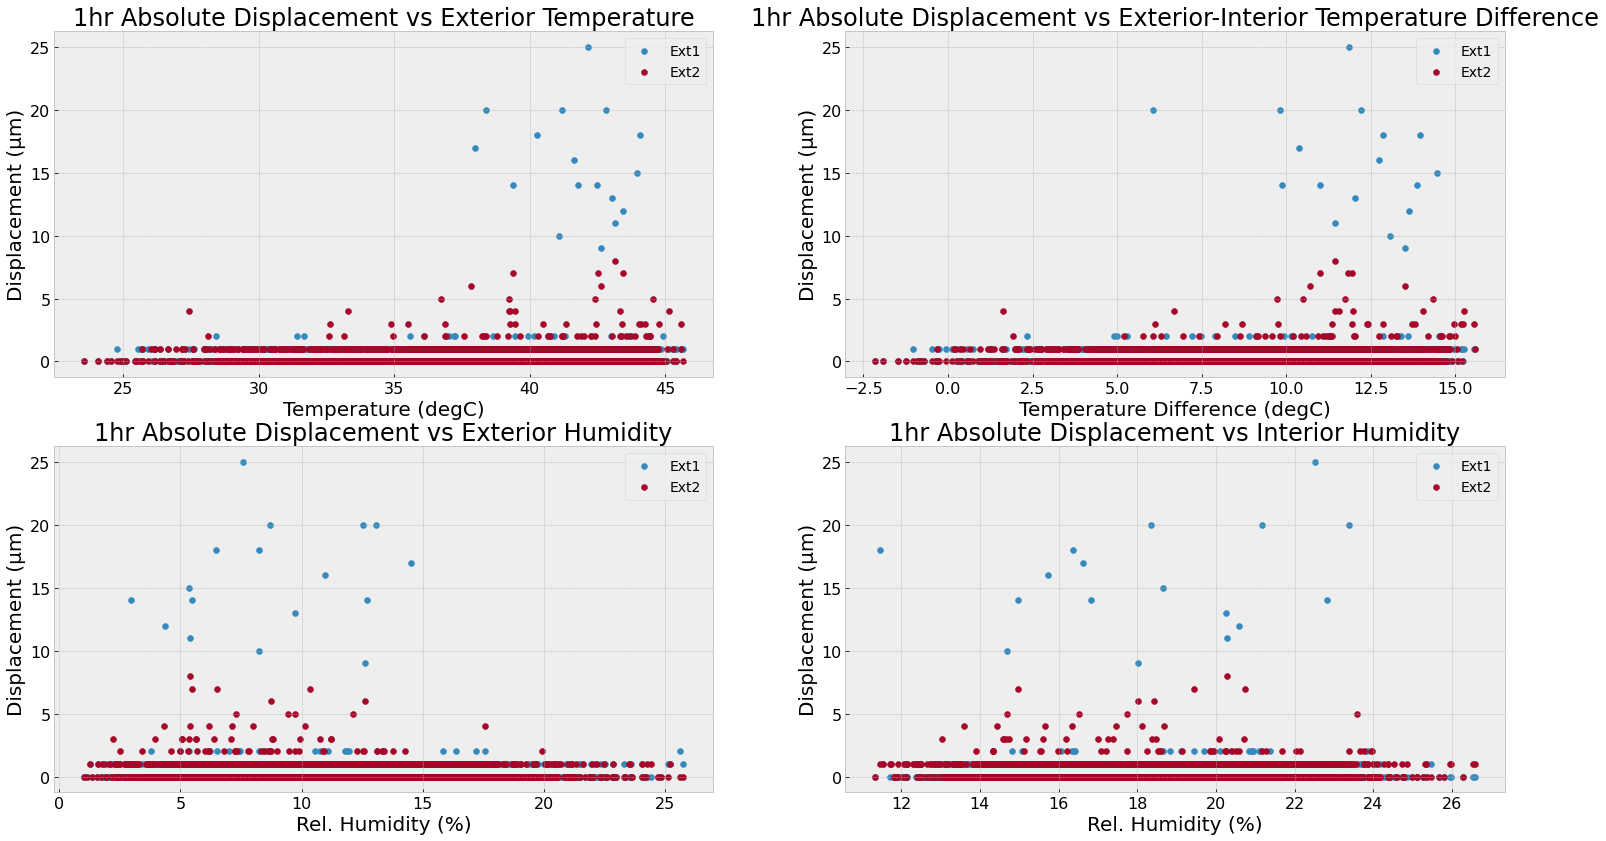

In [17]:
fig, axs = plt.subplots(2,2, figsize=(26,14))


ax=axs[0,0]
ax.scatter(data['air_temp_ib_facade'], np.abs(data['aprtr_change_ext1']), label='Ext1')
ax.scatter(data['air_temp_ib_facade'], np.abs(data['aprtr_change_ext2']), label='Ext2')
ax.set_title('1hr Absolute Displacement vs Exterior Temperature')
ax.set_xlabel('Temperature (degC)')
ax.set_ylabel('Displacement (μm)')
ax.legend()

ax=axs[0,1]
ax.scatter(data['air_temp_ib_facade'] - data['air_temp_ext1'], np.abs(data['aprtr_change_ext1']), label='Ext1')
ax.scatter(data['air_temp_ib_facade'] - data['air_temp_ext1'], np.abs(data['aprtr_change_ext2']), label='Ext2')
ax.set_title('1hr Absolute Displacement vs Exterior-Interior Temperature Difference')
ax.set_xlabel('Temperature Difference (degC)')
ax.set_ylabel('Displacement (μm)')
ax.legend()

ax=axs[1,0]
ax.scatter(data['r_humid_ib_facade'], np.abs(data['aprtr_change_ext1']), label='Ext1')
ax.scatter(data['r_humid_ib_facade'], np.abs(data['aprtr_change_ext2']), label='Ext2')
ax.set_title('1hr Absolute Displacement vs Exterior Humidity')
ax.set_xlabel('Rel. Humidity (%)')
ax.set_ylabel('Displacement (μm)')
ax.legend()

ax=axs[1,1]
ax.scatter(data['r_humid_ib_roof'], np.abs(data['aprtr_change_ext1']), label='Ext1')
ax.scatter(data['r_humid_ib_roof'], np.abs(data['aprtr_change_ext2']), label='Ext2')
ax.set_title('1hr Absolute Displacement vs Interior Humidity')
ax.set_xlabel('Rel. Humidity (%)')
ax.set_ylabel('Displacement (μm)')
ax.legend()

plt.show()
# Plot Each standard deviation with a different color
# Plot Humidity difference 

In [18]:
no_jumps_ext1 = data[data['is_jump_ext1'] == False]
no_jumps_ext2 = data[data['is_jump_ext2'] == False]

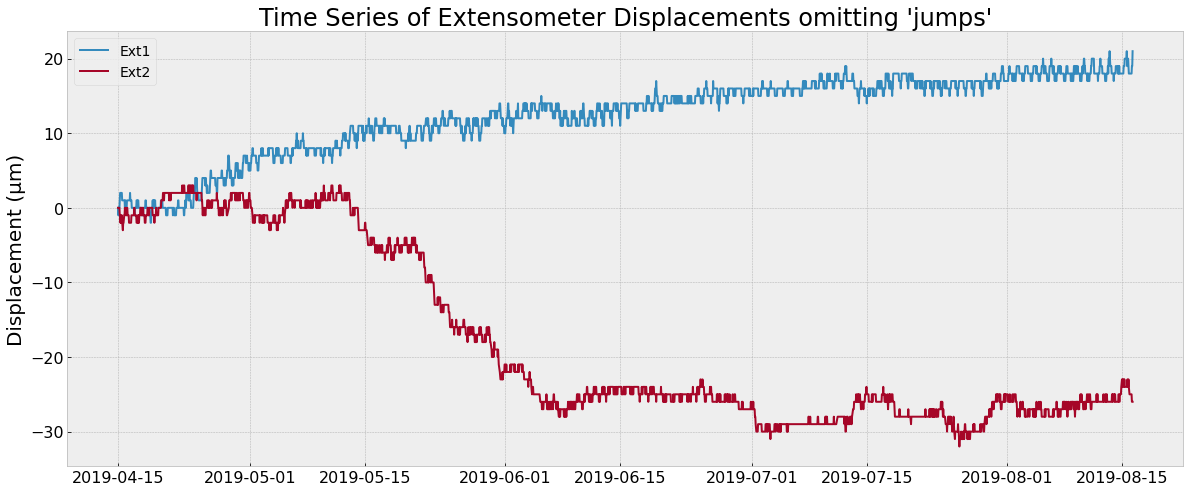

In [19]:
fig , axs = plt.subplots(1,1)

ax=axs
ax.plot(no_jumps_ext1.aprtr_change_ext1.cumsum(), label='Ext1')
ax.plot(no_jumps_ext2.aprtr_change_ext2.cumsum(), label='Ext2')
ax.set_title("Time Series of Extensometer Displacements omitting 'jumps'")
ax.set_ylabel('Displacement (μm)')

ax.legend()

In [20]:
x = data.aprtr_change_ext1.cumsum()
y = data.aprtr_change_ext2.cumsum()


z = np.sqrt(x**2 + y**2)
theta = np.rad2deg(np.arctan2(x,y+0.000001))
theta = (theta + 90) % 360
azimuth = theta.apply(lambda x: x if x > 0 else 360+x)

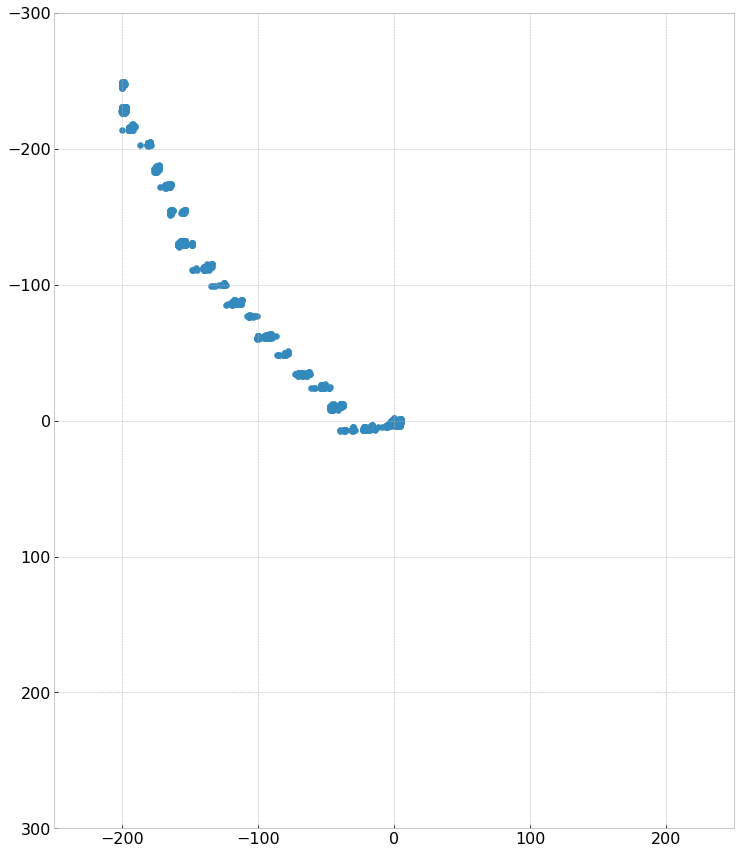

In [21]:
fig, axs = plt.subplots(figsize=(15,15))
ax=axs
ax.scatter(data['aprtr_change_ext2'].cumsum(), data['aprtr_change_ext1'].cumsum())
ax.set_xlim(-250, 250)
ax.set_ylim(-300, 300)

ax.invert_yaxis()
ax.set_aspect(1)
ax.set_facecolor('white')

In [25]:
data['air_temp_ib_roof'].to_excel("Temps190415_190816.xlsx")